# Классификация текстов нейронной сетью

Сравним классификацию текстов [наивным бейсовским методом](01.Classification.Naive-Bayes.ipynb) с нейронной сетью.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import spacy
from tqdm import tqdm

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

In [2]:
train_corpus = fetch_20newsgroups(
    subset="train", remove=("headers", "footers", "quotes")
)

## Токенизация

In [3]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])

In [4]:
def spacy_tokenizer(doc: spacy.tokens.Doc) -> list[str]:
    return [
        token.lemma_.lower()
        for token in doc
        if len(token) > 2 and not token.is_stop and token.is_alpha
    ]

In [5]:
preprocessed_train_corpus = [
    spacy_tokenizer(doc)
    for doc in tqdm(
        nlp.pipe(train_corpus.data, batch_size=256, n_process=-1),
        desc="Preprocessing",
    )
]

Preprocessing: 11314it [00:38, 296.28it/s]


In [6]:
print(preprocessed_train_corpus[0])
print(preprocessed_train_corpus[1])

['wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'small', 'addition', 'bumper', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'engine', 'spec', 'year', 'production', 'car', 'history', 'info', 'funky', 'look', 'car', 'mail']
['fair', 'number', 'brave', 'soul', 'upgrade', 'clock', 'oscillator', 'share', 'experience', 'poll', 'send', 'brief', 'message', 'detail', 'experience', 'procedure', 'speed', 'attain', 'cpu', 'rate', 'speed', 'add', 'card', 'adapter', 'heat', 'sink', 'hour', 'usage', 'day', 'floppy', 'disk', 'functionality', 'floppy', 'especially', 'request', 'summarize', 'day', 'add', 'network', 'knowledge', 'base', 'clock', 'upgrade', 'answer', 'poll', 'thank']


## Train-validation split

In [7]:
train_data, val_data, train_labels, val_labels = train_test_split(
    preprocessed_train_corpus,
    train_corpus.target,
    train_size=0.85,
    random_state=1,
)

In [8]:
print(len(train_data), len(val_data))

9616 1698


## Векторизация

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(
    tokenizer=lambda x: x,
    binary=True,
    lowercase=False,
    token_pattern=None,
    preprocessor=lambda x: x,
)
bow = count_vectorizer.fit_transform(train_data)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,
    lowercase=False,
    token_pattern=None,
    preprocessor=lambda x: x,
)
tfidf_vectorizer.fit(train_data)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,False
,preprocessor,<function <la...x7df3239b7240>
,tokenizer,<function <la...x7df3239b71a0>
,analyzer,'word'
,stop_words,None
,token_pattern,None
,ngram_range,"(1, ...)"


In [11]:
count_vectorizer.get_feature_names_out()

array(['aaa', 'aaaaaaaaaaaa', 'aaah', ..., 'zyxel', 'zzz', 'zzzzzzt'],
      dtype=object)

In [12]:
print(f"Vocabulary size: {len(count_vectorizer.vocabulary_)}")

Vocabulary size: 45392


In [13]:
print(bow[0])

  (0, 36852)	1
  (0, 14602)	1
  (0, 12291)	1
  (0, 471)	1
  (0, 40699)	1
  (0, 9683)	1
  (0, 31125)	1
  (0, 22792)	1
  (0, 17395)	1
  (0, 42019)	1
  (0, 31988)	1
  (0, 39467)	1


In [14]:
feature_names = count_vectorizer.get_feature_names_out()
bow_array = bow[0].toarray().flatten()
nonzero_indexes = bow_array.nonzero()[0]
words_in_doc = [feature_names[i] for i in nonzero_indexes]
print(f"Слова в документе 0 {words_in_doc}")

Слова в документе 0 ['address', 'decide', 'email', 'followup', 'hear', 'like', 'printer', 'question', 'sorry', 'thank', 'try', 'user']


## Обучение модели

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [16]:
torch.manual_seed(42)

In [17]:
class TextDataset(data.Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = torch.tensor(y, dtype=torch.long)
        self.length = len(y)

    def __getitem__(self, index):
        return torch.from_numpy(
            self.X[index].toarray().squeeze()
        ).float(), self.y[index]

    def __len__(self):
        return self.length

In [18]:
NUM_CLASSES = len(train_corpus.target_names)
NUM_FEATURES = len(tfidf_vectorizer.vocabulary_)
NUM_UNITS = 128

NUM_EPOCHS = 15
BATCH_SIZE = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(
    nn.Linear(NUM_FEATURES, NUM_UNITS),
    nn.ReLU(inplace=True),
    nn.Linear(NUM_UNITS, NUM_UNITS),
    nn.ReLU(inplace=True),
    nn.Linear(NUM_UNITS, NUM_CLASSES),
).to(device=device)

optimizer = optim.RMSprop(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train_dataset = TextDataset(
    tfidf_vectorizer.transform(train_data), train_labels
)
val_dataset = TextDataset(tfidf_vectorizer.transform(val_data), val_labels)

train_dataloader = data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_dataloader = data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [19]:
from sklearn.metrics import accuracy_score


def train(model):
    best_model_state_dict = model.state_dict()
    best_accuracy = 0
    history = dict(
        train_loss=[],
        val_loss=[],
        train_accuracy=[],
        val_accuracy=[],
    )
    no_improve, patience = 0, 3
    for epoch in range(NUM_EPOCHS):
        if no_improve == patience:
            print(f"Early stopping at epoch {epoch}")
            break
        model.train()

        train_predicts, train_targets = [], []
        running_loss = 0
        for x_train, y_train in tqdm(
            train_dataloader,
            desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Train]     ",
        ):
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            optimizer.zero_grad()
            outputs = model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

            train_predicts.extend(
                torch.argmax(outputs.cpu().detach(), dim=1).numpy()
            )
            train_targets.extend(y_train.cpu().detach().numpy())

            running_loss += loss.item() * x_train.size(0)

        # epoch train loss
        history["train_loss"].append(running_loss / len(train_dataset))

        model.eval()
        val_predicts, val_targets = [], []
        running_loss = 0
        with torch.no_grad():
            for x_val, y_val in tqdm(
                val_dataloader,
                desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Validation]",
            ):
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                outputs = model(x_val)
                loss = criterion(outputs, y_val)

                val_predicts.extend(
                    torch.argmax(outputs.cpu().detach(), dim=1).numpy()
                )
                val_targets.extend(y_val.cpu().detach().numpy())

                running_loss += loss.item() * x_val.size(0)

            # epoch val loss
            history["val_loss"].append(running_loss / len(val_dataset))

            history["train_accuracy"].append(
                accuracy_score(train_targets, train_predicts)
            )
            history["val_accuracy"].append(
                accuracy_score(val_targets, val_predicts)
            )

        if best_accuracy < history["val_accuracy"][-1]:
            best_accuracy = history["val_accuracy"][-1]
            best_model_state_dict = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1

        print(
            f"Train Loss: {history['train_loss'][-1]:.4f}, Train Acc: {history['train_accuracy'][-1]:.4f}"
        )
        print(
            f"Val Loss:   {history['val_loss'][-1]:.4f}, Val Acc:   {history['val_accuracy'][-1]:.4f}\n"
        )

    print(f"\nBest val accuracy {best_accuracy}")
    model.load_state_dict(best_model_state_dict)
    return history

In [20]:
history = train(model)

Epoch 1/15 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 58.22it/s]


Train Loss: 1.5297, Train Acc: 0.5350
Val Loss:   1.2471, Val Acc:   0.6249



Epoch 2/15 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 55.38it/s]


Train Loss: 0.3916, Train Acc: 0.8797
Val Loss:   1.1877, Val Acc:   0.6961



Epoch 3/15 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 57.37it/s]


Train Loss: 0.1441, Train Acc: 0.9591
Val Loss:   1.3228, Val Acc:   0.6890



Epoch 4/15 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 50.86it/s]


Train Loss: 0.1037, Train Acc: 0.9702
Val Loss:   1.3250, Val Acc:   0.7008



Epoch 5/15 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 65.71it/s]


Train Loss: 0.0993, Train Acc: 0.9703
Val Loss:   1.2790, Val Acc:   0.7120



Epoch 6/15 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 73.38it/s]


Train Loss: 0.0962, Train Acc: 0.9710
Val Loss:   1.3063, Val Acc:   0.7155



Epoch 7/15 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 72.99it/s]


Train Loss: 0.0949, Train Acc: 0.9709
Val Loss:   1.3388, Val Acc:   0.7173



Epoch 8/15 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 79.41it/s]


Train Loss: 0.0942, Train Acc: 0.9714
Val Loss:   1.3810, Val Acc:   0.7126



Epoch 9/15 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 69.10it/s]


Train Loss: 0.0920, Train Acc: 0.9720
Val Loss:   1.6811, Val Acc:   0.6873



Epoch 10/15 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 73.51it/s]

Train Loss: 0.0943, Train Acc: 0.9702
Val Loss:   1.5259, Val Acc:   0.7032

Early stopping at epoch 10

Best val accuracy 0.7173144876325088


In [21]:
import matplotlib.pyplot as plt


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Первый график: Loss (Training и Validation)
    ax1.plot(
        history["train_loss"], label="Train Loss", color="blue", linewidth=2
    )
    ax1.plot(
        history["val_loss"], label="Validation Loss", color="red", linewidth=2
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.set_title("Training and Validation Loss")
    ax1.grid(True, alpha=0.3)

    # Второй график: Accuracy (Training и Validation)
    ax2.plot(
        history["train_accuracy"],
        label="Train Accuracy",
        color="blue",
        linewidth=2,
    )
    ax2.plot(
        history["val_accuracy"],
        label="Validation Accuracy",
        color="red",
        linewidth=2,
    )
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.set_title("Training and Validation Accuracy")
    ax2.grid(True, alpha=0.3)

    # Добавляем общий заголовок для всей фигуры
    fig.suptitle("Model Training Metrics", fontsize=16)

    # Убираем возможное перекрытие элементов
    plt.tight_layout()

    plt.show()

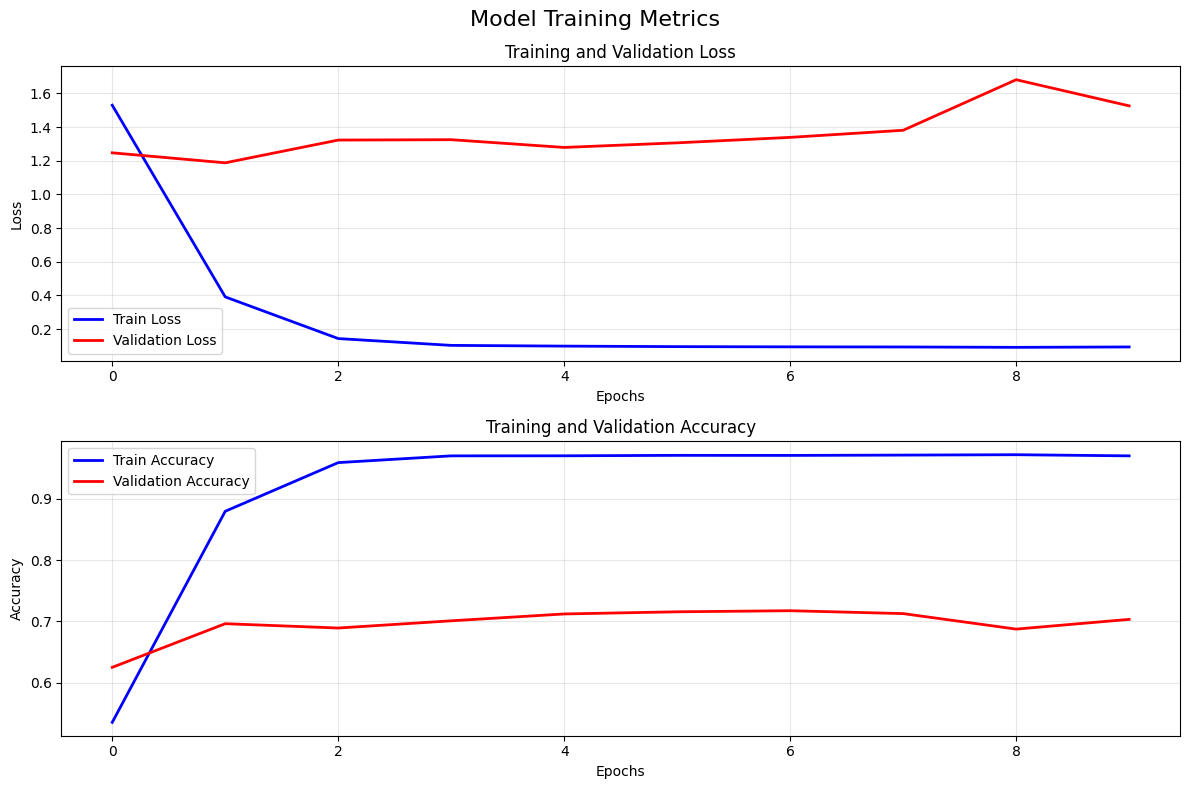

In [22]:
plot_history(history)

**Вывод: Модель переобучается**

## Оценка результатов

In [23]:
test_corpus = fetch_20newsgroups(
    subset="test", remove=("headers", "footers", "quotes")
)

In [24]:
preprocessed_test_corpus = [
    spacy_tokenizer(doc)
    for doc in tqdm(
        nlp.pipe(test_corpus.data, batch_size=256, n_process=-1),
        desc="Preprocessing",
    )
]

Preprocessing: 7532it [00:21, 355.70it/s]


In [25]:
X_test = tfidf_vectorizer.transform(preprocessed_test_corpus)
X_test = torch.tensor(X_test.toarray(), dtype=torch.float).to(device=device)
y_test = torch.tensor(test_corpus.target, dtype=torch.long)

In [26]:
model.eval()
with torch.no_grad():
    outputs = model(X_test).cpu().detach()
predicts = torch.argmax(outputs, dim=1)
loss = criterion(outputs, y_test)
accuracy = accuracy_score(y_test, predicts)

In [27]:
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Test Loss: 2.027278423309326
Test Accuracy: 0.6379447689856612


In [28]:
predicts_probs = torch.softmax(outputs, dim=1)
print(f"Softmax для первого поста:\n {predicts_probs[0]}\n")

print(f"Метка с наибольшей вероятностью для первого поста: {predicts[0]}")
print(f"Класс: {train_corpus.target_names[predicts[0]]}")

Softmax для первого поста:
 tensor([4.9246e-05, 9.1923e-02, 3.5209e-05, 8.3753e-01, 4.6787e-03, 7.1560e-08,
        2.6983e-05, 4.3340e-02, 2.2272e-02, 6.0179e-05, 5.3592e-07, 1.0320e-05,
        6.6277e-05, 1.5326e-06, 1.7533e-07, 1.0363e-07, 7.7459e-09, 9.0212e-06,
        4.8177e-08, 4.1460e-08])

Метка с наибольшей вероятностью для первого поста: 3
Класс: comp.sys.ibm.pc.hardware


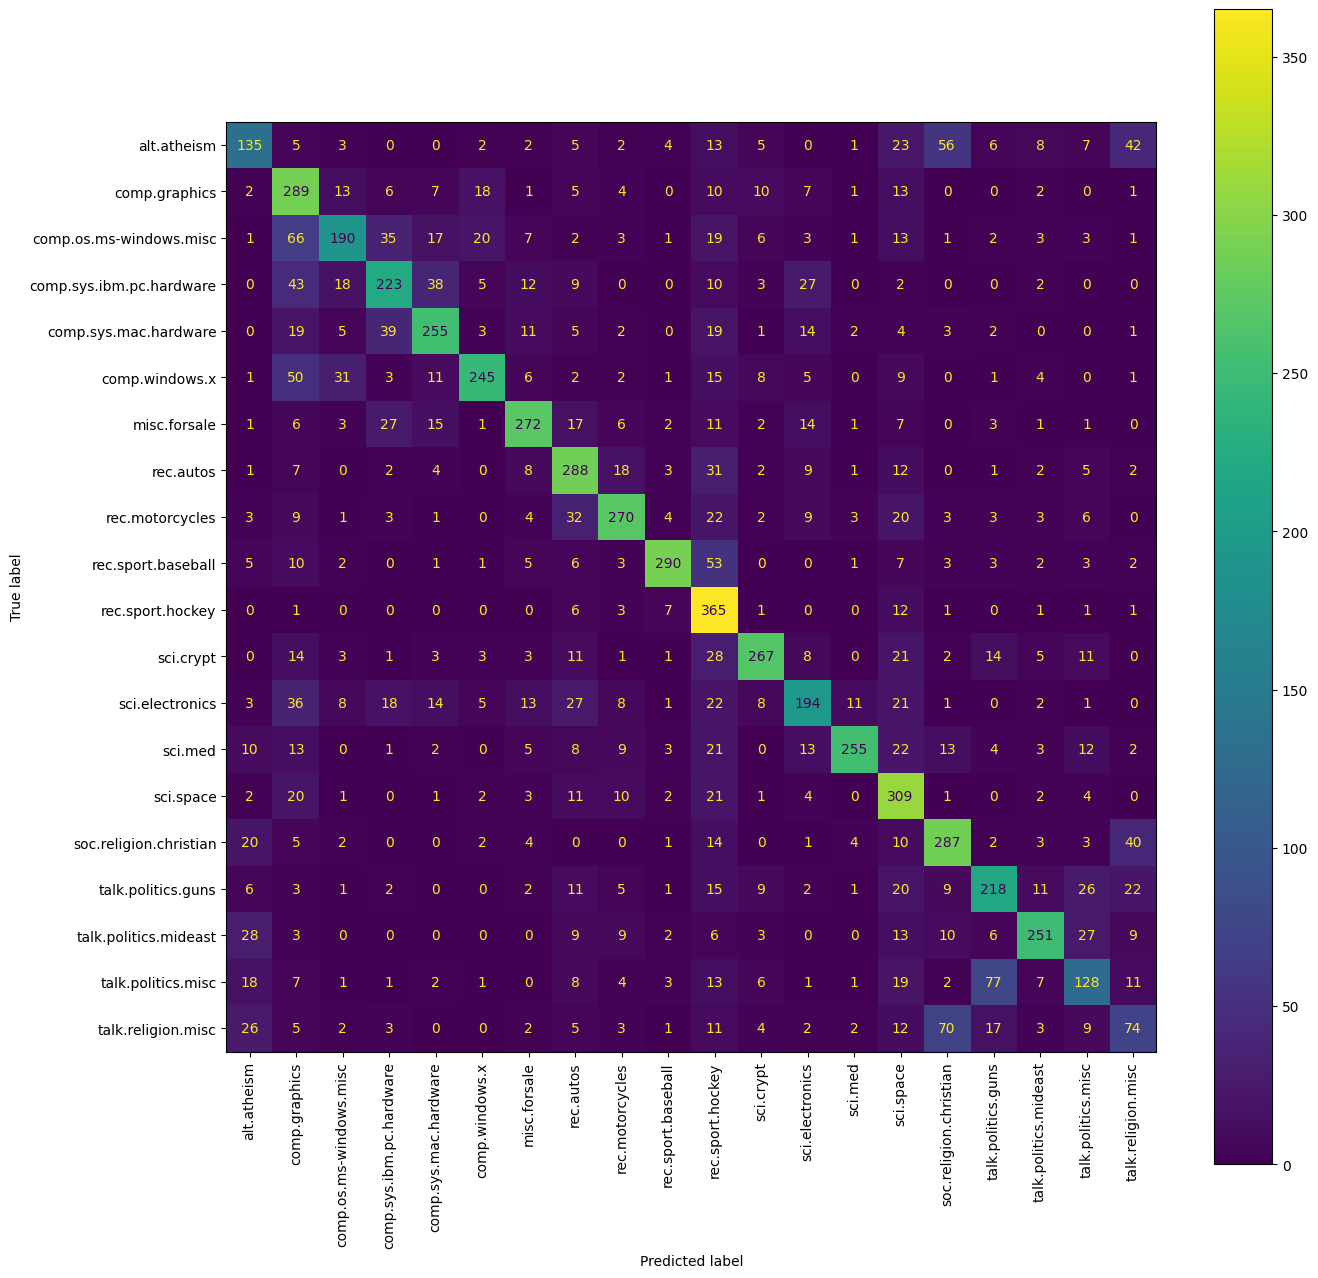

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_corpus.target, predicts)
cmd = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=test_corpus.target_names
)
fig, ax = plt.subplots(figsize=(15, 15))
cmd.plot(ax=ax, xticks_rotation="vertical")

Что можно сказать по confusion matrix:
- Модель совершает ошибки в классах, связанных с компьютерными технологиями (`comp.`), в классах, относящихся к `misc` и религиозные темы `.religion`.

In [30]:
from sklearn.metrics import classification_report

print(
    classification_report(
        test_corpus.target, predicts, target_names=test_corpus.target_names
    )
)

                          precision    recall  f1-score   support

             alt.atheism       0.52      0.42      0.46       319
           comp.graphics       0.47      0.74      0.58       389
 comp.os.ms-windows.misc       0.67      0.48      0.56       394
comp.sys.ibm.pc.hardware       0.61      0.57      0.59       392
   comp.sys.mac.hardware       0.69      0.66      0.67       385
          comp.windows.x       0.80      0.62      0.70       395
            misc.forsale       0.76      0.70      0.73       390
               rec.autos       0.62      0.73      0.67       396
         rec.motorcycles       0.75      0.68      0.71       398
      rec.sport.baseball       0.89      0.73      0.80       397
        rec.sport.hockey       0.51      0.91      0.65       399
               sci.crypt       0.79      0.67      0.73       396
         sci.electronics       0.62      0.49      0.55       393
                 sci.med       0.89      0.64      0.75       396
         

Класс с *низким precision* и *большим recall*

In [31]:
class_of_interest = test_corpus.target_names.index("rec.autos")
class_of_interest

7

- Возьмем посты, которая модель определила в этот класс;
- Возьмем все посты, которая модель неправильно определила;
- Возьмем посты, которая модель неправильно определила в этот класс;

In [32]:
class_preds = torch.where(predicts == class_of_interest)[0]
class_preds

tensor([  13,   27,   28,   29,   60,   62,   77,  114,  142,  143,  169,  171,
         201,  205,  220,  225,  229,  239,  241,  254,  256,  263,  307,  313,
         343,  355,  362,  380,  383,  384,  390,  411,  428,  434,  462,  468,
         478,  497,  506,  534,  568,  603,  617,  645,  648,  655,  661,  667,
         678,  698,  726,  729,  734,  757,  761,  762,  774,  851,  856,  903,
         910,  916,  929,  933,  947,  959,  963,  964,  966,  975, 1055, 1061,
        1071, 1081, 1082, 1102, 1128, 1136, 1142, 1156, 1162, 1171, 1210, 1232,
        1247, 1260, 1309, 1351, 1387, 1402, 1419, 1425, 1439, 1458, 1460, 1469,
        1474, 1490, 1507, 1518, 1527, 1529, 1536, 1538, 1567, 1576, 1641, 1662,
        1695, 1697, 1752, 1755, 1785, 1792, 1800, 1815, 1860, 1862, 1885, 1886,
        1907, 1911, 1921, 1943, 1947, 1950, 1966, 1967, 1987, 1989, 2042, 2056,
        2061, 2095, 2124, 2142, 2149, 2151, 2153, 2156, 2207, 2211, 2218, 2266,
        2279, 2291, 2313, 2325, 2335, 23

In [33]:
misclassified_posts = torch.nonzero(predicts != y_test).squeeze()
misclassified_posts

tensor([   0,    1,    3,  ..., 7525, 7530, 7531])

In [34]:
misclassified_specific = class_preds[
    torch.isin(class_preds, misclassified_posts)
]
misclassified_posts

tensor([   0,    1,    3,  ..., 7525, 7530, 7531])

Взглянем на несколько постов, которая модели неправильно определила в `class_of_interest`

In [35]:
for post_idx in misclassified_specific[:10]:
    print(f"Predicted class: {test_corpus.target_names[predicts[post_idx]]}")
    print(f"True class: {test_corpus.target_names[y_test[post_idx]]}")
    print(f"Post: {preprocessed_test_corpus[post_idx]}")
    print()

Predicted class: rec.autos
True class: rec.motorcycles
Post: ['accusation', 'think', 'recommendation', 'mean', 'grow', 'oughta', 'know', 'bring', 'truck', 'pound', 'crawfish', 'talk']

Predicted class: rec.autos
True class: comp.sys.ibm.pc.hardware
Post: ['know', 'canada', 'hear', 'people', 'translation', 'work', 'papua', 'new', 'quinea', 'like', 'good', 'response', 'service', 'seriously', 'consider', 'buy']

Predicted class: rec.autos
True class: rec.motorcycles
Post: ['have', 'problem', 'instability', 'universal', 'gravitational', 'constant', 'day', 'close', 'get', 'expose', 'fang', 'dripping', 'doubt', 'viscera', 'foolhardy', 'experimenter', 'cum', 'canine', 'psychology', 'big', 'heavy', 'dog', 'appear', 'recall', 'distribution', 'pound', 'operate', 'muscle', 'drive', 'ounce', 'brain', 'possess', 'instinctual', 'heuristic', 'compose', 'equal', 'part', 'bloodlust', 'raven', 'hunger', 'course', 'dog', 'poop', 'vary', 'place', 'dog', 'deposit', 'regularly', 'painstakingly', 'manicure',

Некоторые посты:
1. Имеют только несколько слов, так что их невозможно классифицировать;
2. Имеют такой контекст, что и человеку будет сложно определить класс

## Улучшение модели

Зададим некоторый минимум, который должен содержать пост

In [36]:
def filter_short_texts(doc, min_len):
    return len(doc) >= min_len

In [37]:
len(preprocessed_train_corpus[0])

34

In [38]:
print(
    f"Число тренировочных постов, до удаления маленьких текстов: {len(preprocessed_train_corpus)}"
)

z = zip(preprocessed_train_corpus, train_corpus.target)
f = filter(lambda pair: filter_short_texts(pair[0], 5), z)

preprocessed_train_corpus, train_corpus.target = zip(*f)

print(
    f"Число тренировочных постов, после удаления маленьких текстов: {len(preprocessed_train_corpus)}"
)

Число тренировочных постов, до удаления маленьких текстов: 11314
Число тренировочных постов, после удаления маленьких текстов: 10616


In [39]:
print(
    f"Число тестовых постов, до удаления маленьких текстов: {len(preprocessed_test_corpus)}"
)

z = zip(preprocessed_test_corpus, test_corpus.target)
f = filter(lambda pair: filter_short_texts(pair[0], 5), z)

preprocessed_test_corpus, test_corpus.target = zip(*f)

print(
    f"Число тестовых постов, после удаления маленьких текстов: {len(preprocessed_test_corpus)}"
)

Число тестовых постов, до удаления маленьких текстов: 7532
Число тестовых постов, после удаления маленьких текстов: 7044


In [40]:
# Resplit the training data into train/validation sets.
train_data, val_data, train_labels, val_labels = train_test_split(
    preprocessed_train_corpus,
    train_corpus.target,
    train_size=0.85,
    random_state=1,
)

In [41]:
tfidf_vectorizer.fit(train_data)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,False
,preprocessor,<function <la...x7df3239b7240>
,tokenizer,<function <la...x7df3239b71a0>
,analyzer,'word'
,stop_words,None
,token_pattern,None
,ngram_range,"(1, ...)"


In [42]:
NUM_CLASSES = len(train_corpus.target_names)
NUM_FEATURES = len(tfidf_vectorizer.vocabulary_)
NUM_UNITS = 128

NUM_EPOCHS = 50
BATCH_SIZE = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(
    nn.Linear(NUM_FEATURES, NUM_UNITS),
    nn.ReLU(inplace=True),
    nn.Linear(NUM_UNITS, NUM_UNITS),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(NUM_UNITS, NUM_CLASSES),
    # nn.Softmax(),
).to(device=device)

optimizer = optim.RMSprop(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train_dataset = TextDataset(
    tfidf_vectorizer.transform(train_data), train_labels
)
val_dataset = TextDataset(tfidf_vectorizer.transform(val_data), val_labels)

train_dataloader = data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_dataloader = data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [43]:
history = train(model)

Epoch 1/50 [Validation]: 100%|██████████| 13/13 [00:00<00:00, 59.55it/s]


Train Loss: 1.5715, Train Acc: 0.5200
Val Loss:   0.9246, Val Acc:   0.7357



Epoch 2/50 [Validation]: 100%|██████████| 13/13 [00:00<00:00, 73.32it/s]


Train Loss: 0.3966, Train Acc: 0.8811
Val Loss:   0.9141, Val Acc:   0.7476



Epoch 3/50 [Validation]: 100%|██████████| 13/13 [00:00<00:00, 82.60it/s]


Train Loss: 0.0864, Train Acc: 0.9773
Val Loss:   0.9861, Val Acc:   0.7615



Epoch 4/50 [Validation]: 100%|██████████| 13/13 [00:00<00:00, 62.90it/s]


Train Loss: 0.0240, Train Acc: 0.9945
Val Loss:   1.1089, Val Acc:   0.7640



Epoch 5/50 [Validation]: 100%|██████████| 13/13 [00:00<00:00, 75.75it/s]


Train Loss: 0.0118, Train Acc: 0.9983
Val Loss:   1.1805, Val Acc:   0.7633



Epoch 6/50 [Validation]: 100%|██████████| 13/13 [00:00<00:00, 51.34it/s]


Train Loss: 0.0055, Train Acc: 0.9990
Val Loss:   1.2611, Val Acc:   0.7696



Epoch 7/50 [Validation]: 100%|██████████| 13/13 [00:00<00:00, 75.14it/s]


Train Loss: 0.0052, Train Acc: 0.9990
Val Loss:   1.4203, Val Acc:   0.7621



Epoch 8/50 [Validation]: 100%|██████████| 13/13 [00:00<00:00, 74.28it/s]


Train Loss: 0.0051, Train Acc: 0.9989
Val Loss:   1.3841, Val Acc:   0.7728



Epoch 9/50 [Validation]: 100%|██████████| 13/13 [00:00<00:00, 70.63it/s]


Train Loss: 0.0086, Train Acc: 0.9980
Val Loss:   1.4041, Val Acc:   0.7652



Epoch 10/50 [Validation]: 100%|██████████| 13/13 [00:00<00:00, 76.58it/s]


Train Loss: 0.0090, Train Acc: 0.9982
Val Loss:   1.5339, Val Acc:   0.7633



Epoch 11/50 [Validation]: 100%|██████████| 13/13 [00:00<00:00, 64.27it/s]

Train Loss: 0.0076, Train Acc: 0.9982
Val Loss:   1.4833, Val Acc:   0.7721

Early stopping at epoch 11

Best val accuracy 0.7727558066541117


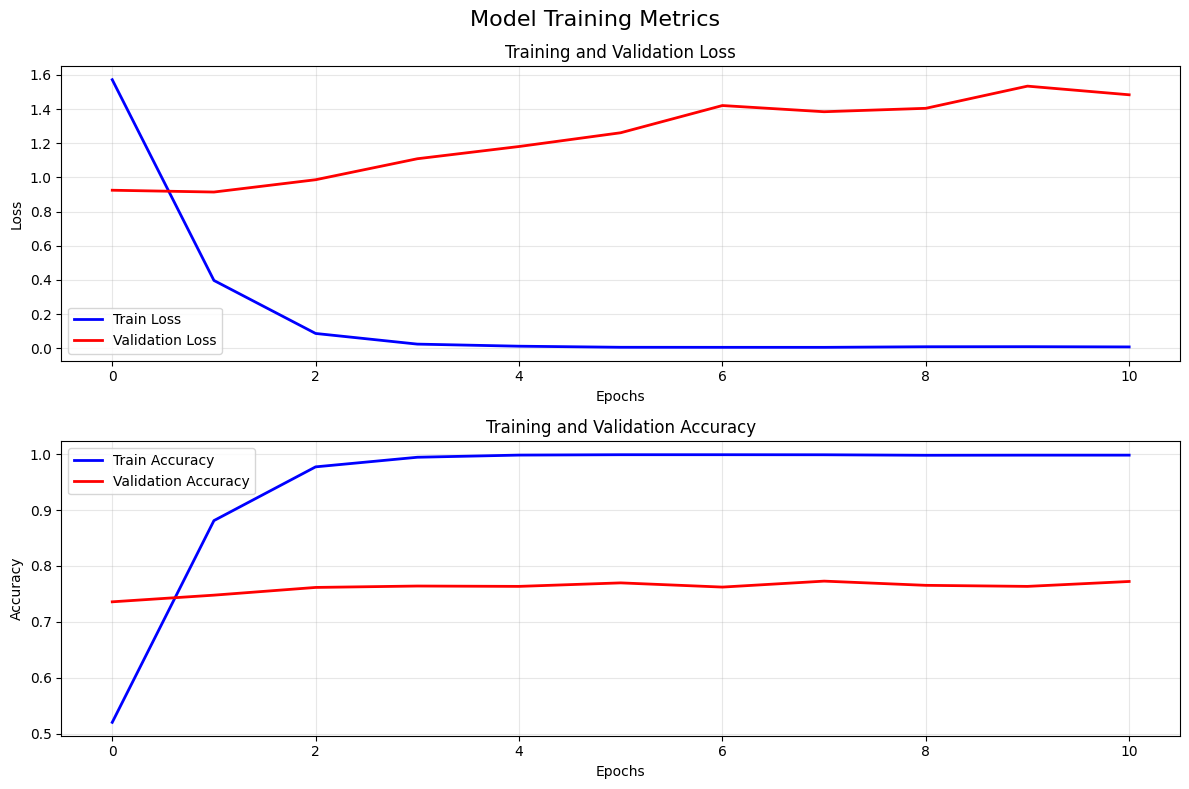

In [44]:
plot_history(history)

In [45]:
X_test = tfidf_vectorizer.transform(preprocessed_test_corpus)
X_test = torch.tensor(X_test.toarray(), dtype=torch.float).to(device=device)

y_test = torch.tensor(test_corpus.target, dtype=torch.long)

In [46]:
model.eval()
with torch.no_grad():
    outputs = model(X_test).cpu().detach()
predicts = torch.argmax(outputs, dim=1)
loss = criterion(outputs, y_test)
accuracy = accuracy_score(y_test, predicts)

In [47]:
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Test Loss: 2.308741331100464
Test Accuracy: 0.6729131175468483


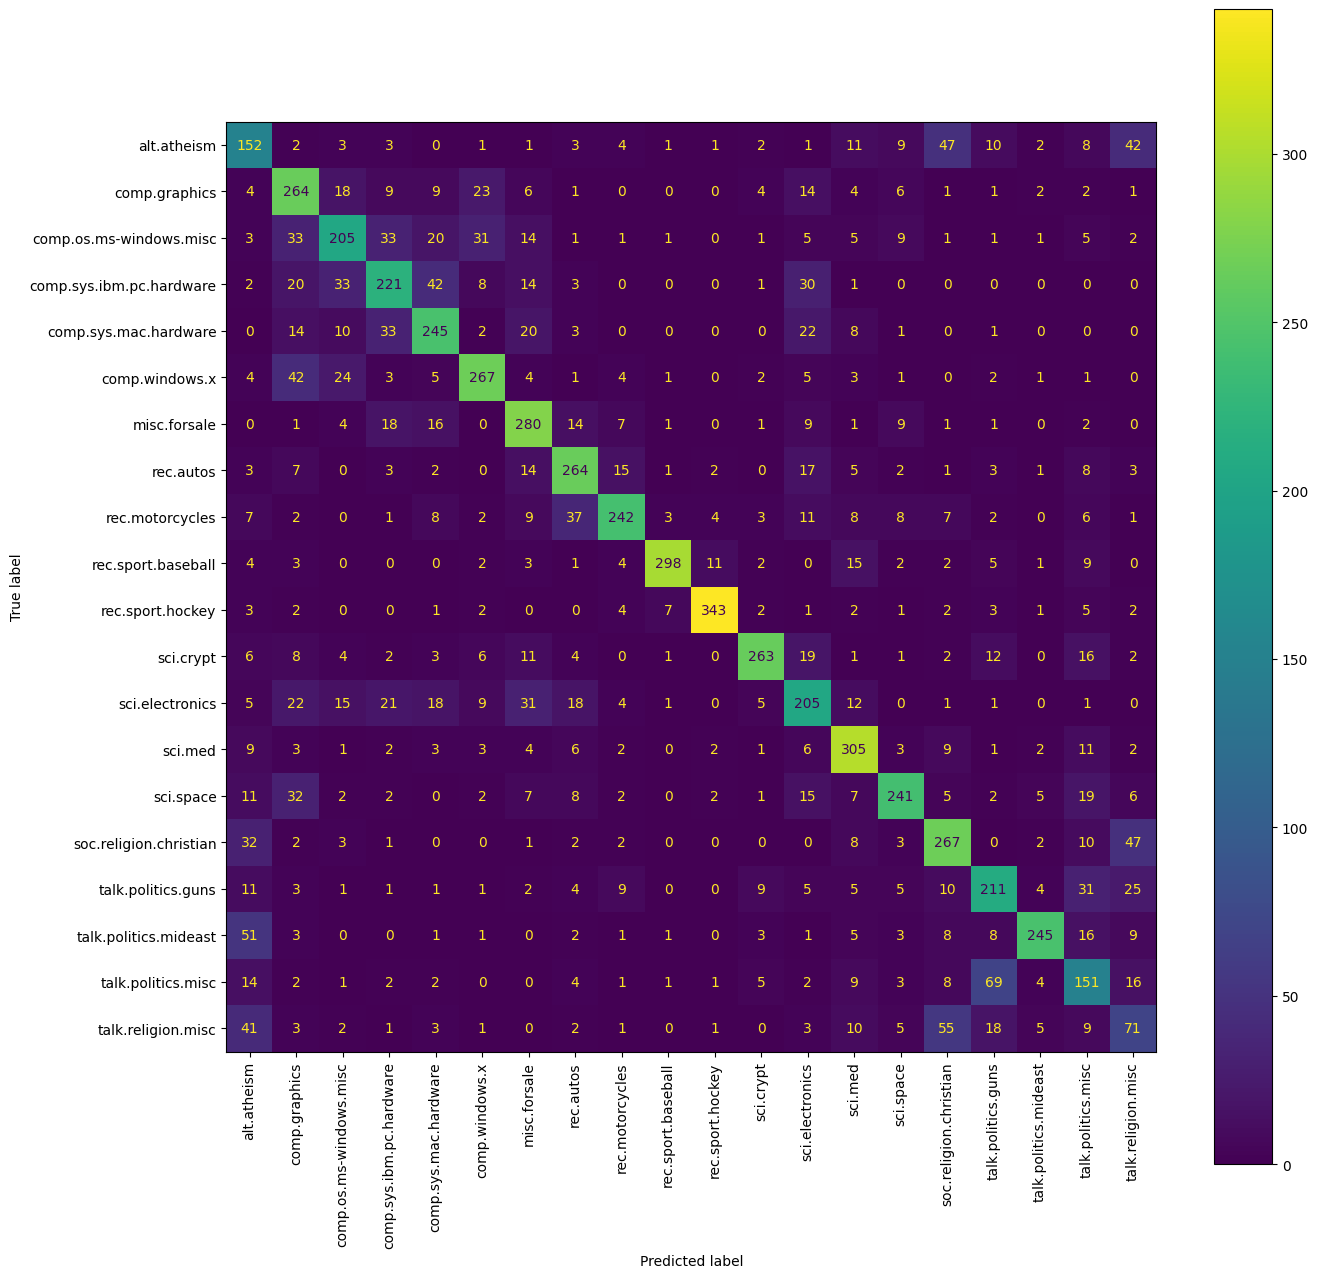

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_corpus.target, predicts)
cmd = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=test_corpus.target_names
)
fig, ax = plt.subplots(figsize=(15, 15))
cmd.plot(ax=ax, xticks_rotation="vertical")

In [49]:
from sklearn.metrics import classification_report

print(
    classification_report(
        test_corpus.target, predicts, target_names=test_corpus.target_names
    )
)

                          precision    recall  f1-score   support

             alt.atheism       0.42      0.50      0.46       303
           comp.graphics       0.56      0.72      0.63       369
 comp.os.ms-windows.misc       0.63      0.55      0.59       372
comp.sys.ibm.pc.hardware       0.62      0.59      0.60       375
   comp.sys.mac.hardware       0.65      0.68      0.66       359
          comp.windows.x       0.74      0.72      0.73       370
            misc.forsale       0.67      0.77      0.71       365
               rec.autos       0.70      0.75      0.72       351
         rec.motorcycles       0.80      0.67      0.73       361
      rec.sport.baseball       0.94      0.82      0.88       362
        rec.sport.hockey       0.93      0.90      0.92       381
               sci.crypt       0.86      0.73      0.79       361
         sci.electronics       0.55      0.56      0.55       369
                 sci.med       0.72      0.81      0.76       375
         

Инференс

In [50]:
target_names = test_corpus.target_names.copy()

model.eval()


def classify_post(post):
    tokenized = [spacy_tokenizer(nlp(post))]
    vectorized_post = tfidf_vectorizer.transform(tokenized)
    vectorized_post = torch.tensor(
        vectorized_post.toarray(), dtype=torch.float, device=device
    )
    with torch.no_grad():
        outputs = model(vectorized_post).squeeze().cpu().detach()
    pred = np.argmax(outputs).item()
    return target_names[pred], torch.softmax(outputs, dim=0)[pred]

In [51]:
# Post from r/medicine.
s = "New primary care attending here. Why are all my new patients age 60-80 yo on Ambien? Serious question, why? Was there a strong marketing push at this time frame? Was it given out like candy to anyone who said they had some trouble with sleep? Was there any discussion of risks and duration of therapy? Has anyone had success/tips for weaning them off of it?"
classify_post(s)

('sci.med', tensor(1.0000))

In [52]:
# Post from r/space.
s = "James Webb Space Telescope has successfully deployed its forward sunshield pallet! Next up: aft sunshield deployment"
classify_post(s)

('sci.space', tensor(0.9997))

In [53]:
# Post from r/cars.
s = "Cars made in the last 10 years with a 4 Speed Manual Transmission? As per the title really, I’m wondering if any vehicles have been made in the last 10 years that still utilise a 4 speed (or less) manual transmission. My Google research has thus far not turned up any results."
classify_post(s)

('rec.autos', tensor(0.9631))

In [54]:
# Post from r/electronics.
s = "This project is powered by an ATTiny85. Five of its pins were used, three of them for the MAX7219 module controling the 7-segment display and one for the button and piezo buzzer respectively. The user can give input through the button. A normal short press to count one up and a long 6-second press to reset it to 0. I also added a simple switch. The microcontroller stores the value in its EEPROM so it doesn't lose it when powered off. I used a charger of an old phone as a power supply. My dad was really excited when he got it for Christmas and it should certainly help him quit smoking :)"
classify_post(s)

('sci.electronics', tensor(1.0000))

В итоге получена модель, которая по производительности сопоставима с naive bayes classifier. Для улучшения результатов можно:

- попробовать разные режимы tokenizer (например, count или TF-IDF);
- отфильтровать слова по частоте (например, нижние и верхние 20%);
- использовать больше данных для обучения;
- применить другой optimizer;
- настроить regularization. <br><br>

Существенного прироста добиться сложно по ряду причин:

- без metadata многие посты остаются настолько неоднозначными, что их трудно классифицировать даже человеку;
- BoW или tf-idf encoding имеет серьёзные ограничения: он большой по размеру, но не несёт информации, кроме факта присутствия слова. Потеря контекста особенно заметна при пересечении тем, что снижает accuracy;
- input vectors слишком широкие и разреженные, поэтому приходится сильно сокращать их уже в первом слое. Если бы первый слой содержал, например, 20,000 units (около половины vocabulary), то он включал бы свыше 800 миллионов parameters, что неадекватно для задачи такого масштаба.
